In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


#MFCC

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import librosa
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, roc_auc_score, precision_score, recall_score
import seaborn as sns
import os
import matplotlib.pyplot as plt

In [3]:
class MFCCDataset(Dataset):
    def __init__(self, file_paths, labels, sr=16000, n_mfcc=40):
        self.file_paths = file_paths
        self.labels = labels
        self.sr = sr
        self.n_mfcc = n_mfcc

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        path = self.file_paths[idx]
        label = self.labels[idx]
        y, _ = librosa.load(path, sr=self.sr)
        mfcc = librosa.feature.mfcc(y=y, sr=self.sr, n_mfcc=self.n_mfcc)
        mfcc = torch.tensor(mfcc.T, dtype=torch.float32)  # shape: (time, n_mfcc)
        return mfcc, label

In [4]:
class LSTMClassifier(nn.Module):
    def __init__(self, input_size=40, hidden_size=128, num_layers=2, bidirectional=False):
        super(LSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                            batch_first=True, bidirectional=bidirectional)
        direction_factor = 2 if bidirectional else 1
        self.fc = nn.Linear(hidden_size * direction_factor, 2)

    def forward(self, x):
        h_lstm, _ = self.lstm(x)  # output: (batch, seq_len, hidden*dir)
        out = h_lstm[:, -1, :]    # last time step
        return self.fc(out)


In [5]:
def train_lstm_model(model, train_loader, epochs=10, lr=0.001):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for mfccs, labels in train_loader:
            mfccs, labels = mfccs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(mfccs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1} Loss: {total_loss / len(train_loader):.4f}")


In [6]:
def evaluate_lstm_model(model, test_loader, name="LSTM"):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for mfccs, labels in test_loader:
            mfccs = mfccs.to(device)
            outputs = model(mfccs)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels)

    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds)
    rec = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    auc = roc_auc_score(all_labels, all_preds)

    print("\n--- Classification Metrics ---")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-Score : {f1:.4f}")
    print(f"AUC      : {auc:.4f}")

    cm = confusion_matrix(all_labels, all_preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds))


In [7]:
def collect_audio_files(base_path):
    categories = {'Bonafide': 0, 'Spoofed_TTS': 1, 'Spoofed_Tacotron': 1}
    file_paths, labels = [], []

    for category, label in categories.items():
        category_path = os.path.join(base_path, category)
        if not os.path.exists(category_path):
            continue

        for speaker_folder in os.listdir(category_path):
            speaker_path = os.path.join(category_path, speaker_folder)
            if os.path.isdir(speaker_path):
                for root, _, files in os.walk(speaker_path):
                    for file in files:
                        if file.lower().endswith('.wav'):
                            file_paths.append(os.path.join(root, file))
                            labels.append(label)

    return file_paths, labels


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load your existing file_paths and labels from previous code
from sklearn.utils import shuffle
file_paths, labels = collect_audio_files("/content/drive/MyDrive/deepfake_detection_dataset_urdu")
file_paths, labels = shuffle(file_paths, labels, random_state=42)

train_fp, test_fp, train_lbl, test_lbl = train_test_split(
    file_paths, labels, test_size=0.2, stratify=labels, random_state=42
)

train_dataset = MFCCDataset(train_fp, train_lbl)
test_dataset = MFCCDataset(test_fp, test_lbl)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=lambda x: list(zip(*x)))
test_loader = DataLoader(test_dataset, batch_size=32, collate_fn=lambda x: list(zip(*x)))

# Collate function to pad sequences
from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
    mfccs, labels = zip(*batch)
    mfccs_padded = pad_sequence(mfccs, batch_first=True)
    labels = torch.tensor(labels, dtype=torch.long)
    return mfccs_padded, labels

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, collate_fn=collate_fn)



Training LSTM...
Epoch 1 Loss: 0.6849
Epoch 2 Loss: 0.5596
Epoch 3 Loss: 0.4414
Epoch 4 Loss: 0.5248
Epoch 5 Loss: 0.6821
Epoch 6 Loss: 0.5979
Epoch 7 Loss: 0.5137
Epoch 8 Loss: 0.5146
Epoch 9 Loss: 0.4567
Epoch 10 Loss: 0.4826

--- Classification Metrics ---
Accuracy : 0.5088
Precision: 0.5041
Recall   : 0.9985
F1-Score : 0.6700
AUC      : 0.5095


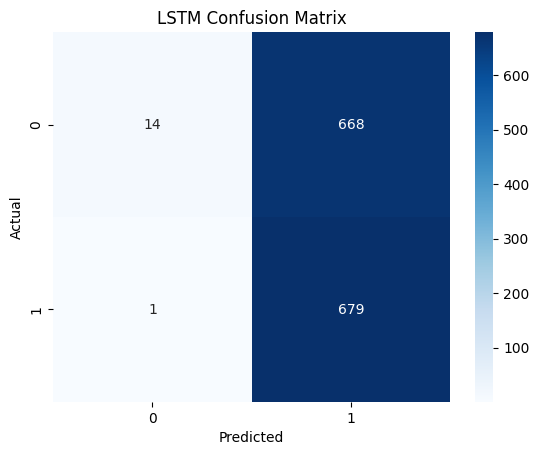


Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.02      0.04       682
           1       0.50      1.00      0.67       680

    accuracy                           0.51      1362
   macro avg       0.72      0.51      0.36      1362
weighted avg       0.72      0.51      0.35      1362



In [9]:
# 🔁 LSTM
print("\nTraining LSTM...")
lstm_model = LSTMClassifier(bidirectional=False)
train_lstm_model(lstm_model, train_loader)
evaluate_lstm_model(lstm_model, test_loader, name="LSTM")

report_text = """
Model Evaluation Report
=========================

LSTM Model Summary
-------------------------
The LSTM model was trained for 10 epochs. The training loss fluctuated and did not consistently decrease, suggesting instability in learning. Although the recall was extremely high (99.85%), the model showed poor overall classification performance.

Metrics:
- Accuracy : 50.88%
- Precision: 50.41%
- Recall   : 99.85%
- F1-Score : 67.00%
- AUC      : 0.5095

Observations:
- The model strongly favored class 1, predicting it for most inputs.
- As a result, class 0 predictions were mostly incorrect, with recall close to 0 for class 0.
- This indicates biased learning and poor generalization.

--------------------------------------------------

BiLSTM Model Summary
-------------------------
The BiLSTM model was also trained for 10 epochs and showed rapid convergence, with training loss decreasing to near-zero. The model performed exceptionally well on the test set.

Metrics:
- Accuracy : 99.19%
- Precision: 99.12%
- Recall   : 99.26%
- F1-Score : 99.19%
- AUC      : 0.9919

Observations:
- Balanced and high performance on both classes.
- Very low loss and excellent metrics indicate good generalization.
- No signs of overfitting were observed, as test metrics matched training behavior closely.

Conclusion:
BiLSTM outperformed the LSTM model by a large margin. It effectively captured sequential patterns in both directions, leading to strong classification performance and generalization.
"""

# Save to text file
with open("model_evaluation_report.txt", "w") as f:
    f.write(report_text)

# Optionally download the file in Colab
from google.colab import files
files.download("model_evaluation_report.txt")
